# 归一化割实验

## 实验目的
试使用Normalized Cut方法对教学楼图像进行分割。

## 实验环境
- NumPy
- OpenCV2
- Scikit-Image
- MatPlotLib

## 实验原理

### Normalized Cut

Normalized Cut (Ncut) 是一种基于图论的图像分割方法。它将图像建模为无向加权图 $G=(V, E)$，其中 $V$ 是节点集合（代表像素或超像素），$E$ 是边集合，表示节点之间的相似关系。边的权重 $w(i, j)$ 反映了节点 $i$ 和 $j$ 之间的相似程度。 

Ncut 的目标是将图划分为两个部分，使得：
1. 划分后不同子图之间的关联性尽可能小；
2. 划分后的每个子图内部的关联性尽可能高。

#### 目标函数

假设将图 $G$ 划分为两个子图 $A$ 和 $B$，Normalized Cut 目标函数定义为：

$$
\text{Ncut}(A, B) = \frac{\text{cut}(A, B)}{\text{assoc}(A, V)} + \frac{\text{cut}(A, B)}{\text{assoc}(B, V)}
$$

其中：
- $\text{cut}(A, B) = \sum_{i \in A, j \in B} w(i, j)$ 表示子图 $A$ 和 $B$ 之间的权重之和；
- $\text{assoc}(A, V) = \sum_{i \in A, j \in V} w(i, j)$ 表示 $A$ 与整个图 $V$ 的权重总和。

Ncut 最小化这个目标函数，以获得良好的图像分割。

#### 矩阵形式与广义特征值问题

图拉普拉斯矩阵 $$L = D - W$$

其中：
- 相似度矩阵：$W$，其中 $W(i, j) = w(i, j)$ 表示节点 $i$ 和 $j$ 的相似度；
- 度矩阵：$D$ 是对角矩阵，$D(i, i) = \sum_j W(i, j)$ 表示节点 $i$ 的度。

Ncut 的问题可以转化为广义特征值问题：

$$
(L y) = \lambda (D y)
$$

其中，$\lambda$ 是特征值，$y$ 是对应的特征向量。第二小的特征值对应的特征向量可以进行分割。


#### RAG（Region Adjacency Graph）

为了减少计算复杂度，我们使用区域邻接图（RAG，Region Adjacency Graph）。在 RAG 中，每个节点代表一个区域（超像素），边的权重表示两个相邻区域之间的相似度。RAG 的构建可以基于颜色均值或其他特征。

我们使用 `skimage.future.graph.rag_mean_color` 构建 RAG，该函数将每个区域的平均颜色作为特征，计算其相似性。

### 预分割

在正式应用 Ncut 之前，我们使用 Felzenszwalb 算法进行预分割。Felzenszwalb 是一种基于图的分割算法，通过计算邻接像素之间的差异和区域一致性来生成超像素：
1. 计算像素之间的相似度（基于颜色或纹理）。
2. 将相似像素合并成若干个区域（超像素）。
3. 输出的区域可以作为 Ncut 的初始输入，以减少计算复杂度。

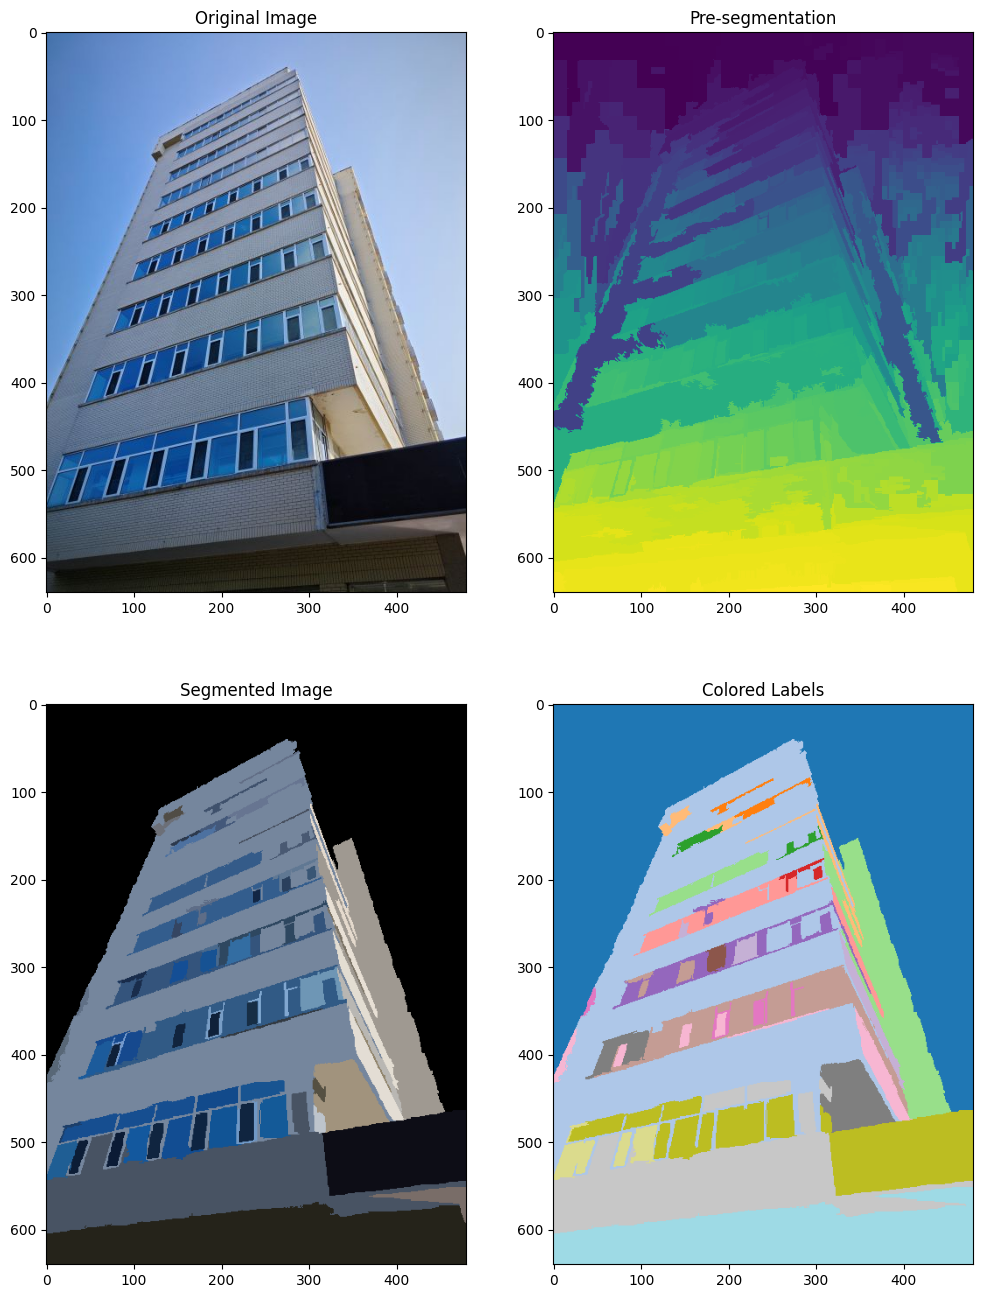

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph
from utils.seg_viz import color_labels

# 读取图像
image = cv2.imread('example.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 预分割图像（以获得更好的分割起点）
pre_segments = segmentation.felzenszwalb(image, scale=100, sigma=0.5, min_size=100)

# 构建RAG
rag = graph.rag_mean_color(image, pre_segments, mode='similarity')

# 使用 Normalized Cut 方法分割图像
labels = graph.cut_normalized(pre_segments, rag)

# 将每个标签染色为不同颜色
segmented_image = color.label2rgb(labels, image, kind='avg')
colored_labels = color_labels(labels)

# 显示结果
plt.figure(figsize=(12, 16))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(pre_segments)
plt.title('Pre-segmentation')

plt.subplot(2, 2, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.subplot(2, 2, 4)
plt.imshow(colored_labels)
plt.title('Colored Labels')

plt.show()


可以看到，预分类后天空和外墙仍然被分割为多个部分；使用NCut后，外墙基本被合并到一个部分，天空被合并成一个部分，窗户被部分正确分割，但越远处玻璃反光影响越大，更难被正确处理。总的来说，这种先预分割后NCut的方式平衡了算力要求和准确度，不易受到外墙瓷砖条纹、天空云层等干扰，效果较好。